In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import datetime as dt
import calendar

from datetime import datetime
from scipy.stats import norm, skew
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score, f1_score, accuracy_score, ConfusionMatrixDisplay

### Feature Engineering Project on traffic Data
#### Generate effective features for predicting traffic volumes from data available a day in advance.

######  From this dataset, six main features are present, date_time = DateTime Hour of the data collected in local CST time, rain_1h=Numeric Amount in mm of rain that occurred in the hour, snow_1h = Numeric Amount in mm of snow that occurred in the hour, temp = Numeric Average temp in kelvin, clouds_all= Numeric Percentage of cloud cover and traffic_volume =  Numeric ( The target feature for the dataset. 

##### Step 1:  
######  Load the dataset into a dataframe that can be used for predicting  traffic_volume a day in advance:


In [4]:
metro_traffic = pd.read_csv('metro_traffic_15_19.csv')
print(metro_traffic.shape, metro_traffic.dtypes)
metro_traffic.head(3)

(32047, 6) date_time          object
rain_1h           float64
snow_1h           float64
temp              float64
clouds_all          int64
traffic_volume      int64
dtype: object


,date_time,rain_1h,snow_1h,temp,clouds_all,traffic_volume
0,2015-07-01 00:00:00,0.0,0.0,289.20,1,737
1,2015-07-01 01:00:00,0.0,0.0,289.40,1,444
2,2015-07-01 02:00:00,0.0,0.0,289.19,1,347


In [3]:
print(metro_traffic.info())
# we have no missing values in this dataset

metro_traffic.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32047 entries, 0 to 32046
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date_time       32047 non-null  object 
 1   rain_1h         32047 non-null  float64
 2   snow_1h         32047 non-null  float64
 3   temp            32047 non-null  float64
 4   clouds_all      32047 non-null  int64  
 5   traffic_volume  32047 non-null  int64  
dtypes: float64(3), int64(2), object(1)
memory usage: 1.5+ MB
None


,rain_1h,snow_1h,temp,clouds_all,traffic_volume
count,32047.000000,32047.000000,32047.000000,32047.000000,32047.000000
mean,0.419653,0.000335,282.892641,47.403782,3258.209910
std,54.924907,0.010015,12.123625,39.730094,1974.058455
min,0.000000,0.000000,243.390000,0.000000,0.000000
25%,0.000000,0.000000,273.880000,1.000000,1196.000000
50%,0.000000,0.000000,285.080000,40.000000,3412.000000
75%,0.000000,0.000000,292.700000,90.000000,4912.000000
max,9831.300000,0.510000,310.070000,100.000000,7280.000000


##### Preprocessing the dataset is vital to ensure that the features extracted can perform well inregards to predicting the traffic volume a day inadvance (Note: more can be done to employ unique approaches here).

###### My initial approach is to find and eliminate any outliers that may affect the prediction models.

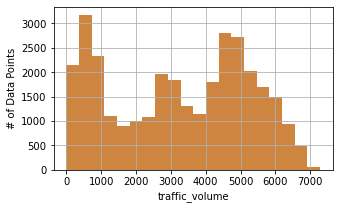

Skewness: -0.108006
Kurtosis: -1.310084


C:\Users\L470\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


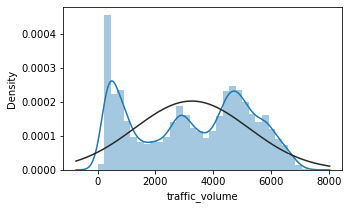

C:\Users\L470\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


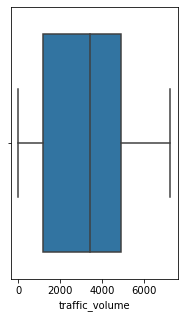

In [4]:
# Searching for  outliers:
attribute = 'traffic_volume'
plt.figure(figsize=(5,3))
plt.hist(metro_traffic[attribute], bins=20, color='peru')
plt.xlabel(attribute)
plt.ylabel('# of Data Points')
plt.grid(True)
plt.show()

print("Skewness: %f" % metro_traffic['traffic_volume'].skew())
print("Kurtosis: %f" % metro_traffic['traffic_volume'].kurt())

plt.figure(figsize=(5,3))
sns.distplot(metro_traffic['traffic_volume'], kde=True, fit=norm)
plt.show()

plt.figure(figsize=(3,5))
sns.boxplot('traffic_volume', data = metro_traffic)
plt.show()
#No outliers found.

C:\Users\L470\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


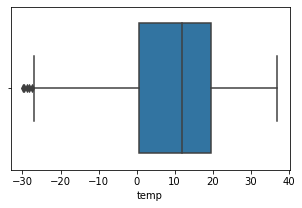

Skewness: -0.469473
Kurtosis: -0.516241


In [5]:
metro_traffic['temp'] = (metro_traffic['temp']-273.15) # Adjusting Temp measurement to celsius from kelvin 0k - 273.15

attribute = 'temp'
# plt.figure(figsize=(8,6))
# plt.hist(metro_traffic[attribute], bins=20, color='peru')
# plt.xlabel(attribute)
# plt.ylabel('# of Data Points')
# plt.grid(True)
# plt.show()


# plot distribution of temp from the data
plt.figure(figsize=(5,3))
sns.boxplot('temp', data = metro_traffic)
plt.show()

print("Skewness: %f" % metro_traffic['temp'].skew())
print("Kurtosis: %f" % metro_traffic['temp'].kurt())

# plt.figure(figsize=(8,6))
# sns.distplot(metro_traffic['temp'], kde=True, fit=norm)
# plt.show()

# Outliers found in the temp column, The outliers are at the lower end of the box plot . Hence this could skew the data to the left.

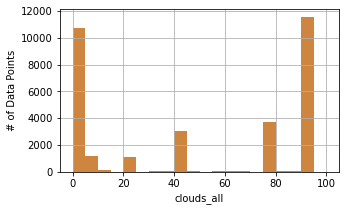

Skewness: -0.101781
Kurtosis: -1.804238


In [6]:
attribute = 'clouds_all'
plt.figure(figsize=(5,3))
plt.hist(metro_traffic[attribute], bins=20, color='peru')
plt.xlabel(attribute)
plt.ylabel('# of Data Points')
plt.grid(True)
plt.show()

print("Skewness: %f" % metro_traffic['clouds_all'].skew())
print("Kurtosis: %f" % metro_traffic['clouds_all'].kurt())
# This column represents the cloud coverage in percentage (this might have to be converted to categorical data)

C:\Users\L470\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


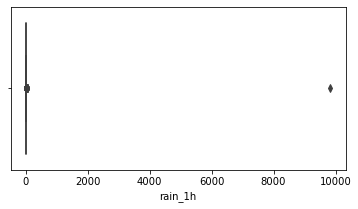

Skewness: 178.946283
Kurtosis: 32030.162324


In [7]:
attribute = 'rain_1h'

plt.figure(figsize=(6,3))
sns.boxplot('rain_1h', data = metro_traffic)
plt.show()

print("Skewness: %f" % metro_traffic['rain_1h'].skew())
print("Kurtosis: %f" % metro_traffic['rain_1h'].kurt())

#This column does have outliers that are extremely far from the upper limit hence it is highly skewed to its right . ( this will be best represented in a binary form)

C:\Users\L470\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


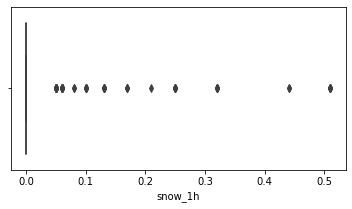

Skewness: 39.426320
Kurtosis: 1740.762695


In [8]:
attribute = 'snow_1h'

plt.figure(figsize=(6,3))
sns.boxplot('snow_1h', data = metro_traffic)
plt.show()

print("Skewness: %f" % metro_traffic['snow_1h'].skew())
print("Kurtosis: %f" % metro_traffic['snow_1h'].kurt())
# Similarly to the rain_1h column this  column does have values far from its upper limit  and it is highly skewed to its right . (Convert column to categorical with a Binary approach as well)

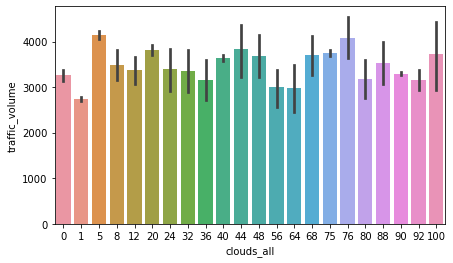

In [9]:
plt.figure(figsize=(7,4))
sns.barplot(x='clouds_all', y = 'traffic_volume', data = metro_traffic)
plt.show()

###### The next approach is to ensure that the features; rain_1h, snow_1h and cloud_all are converted to categorical features as this will ensure they make more effective features. 

###### Since rain_1h and snow_1h are very close to zero( both are extremely skewed, partly due to the outliers; converting them to categorical features with a binary output ( for example rained, no rain) has been opted for.

###### Whilst for the cloud_all column ( proportion of cloud coverage) will be converted to a categorical variable as well. This will have 5 categories of cloud cover. This approach will ensure that large percentage scales do not affect the model.

In [10]:
df = metro_traffic.copy()

In [11]:
# change encoding for rain_1h 
def modify_rain_1h(x):
    if x > 0 :
        return 'Rained'
    else:
        return 'No_Rain'
    
df['rain_1h'] = df.rain_1h.map(modify_rain_1h)

In [12]:
# change encoding for snow_1h

def modify_snow_1h(x):
    if x > 0 :
        return 'Snowed'
    else:
        return 'No_Snow'
    
df['snow_1h'] = df.snow_1h.map(modify_snow_1h)

In [13]:
# Different types of cloud cover conditions include SKC (sky clear), FEW (trace), SCT (scattered), BKN (broken) and OVC (overcast). 

def modify_cloud(x):
    if x < 20:
        return 'clear_sky'
    elif x >= 20 & x <40:
        return 'trace_sky'
    elif x>=40 & x < 60:
        return 'scattered_sky'
    elif x>=60 & x<80:
        return 'broken_sky'
    else:
        return 'overcast'
df['clouds_all'] = df.clouds_all.map(modify_cloud)

In [14]:
df.head()

,date_time,rain_1h,snow_1h,temp,clouds_all,traffic_volume
0,2015-07-01 00:00:00,No_Rain,No_Snow,16.05,clear_sky,737
1,2015-07-01 01:00:00,No_Rain,No_Snow,16.25,clear_sky,444
2,2015-07-01 02:00:00,No_Rain,No_Snow,16.04,clear_sky,347
3,2015-07-01 03:00:00,Rained,No_Snow,15.59,clear_sky,356
4,2015-07-01 04:00:00,No_Rain,No_Snow,14.92,clear_sky,936


In [15]:
df.dtypes

date_time          object
rain_1h            object
snow_1h            object
temp              float64
clouds_all         object
traffic_volume      int64
dtype: object

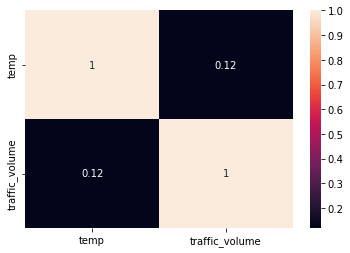

In [16]:
corrMatrix = round(df.corr(), 2)
sns.heatmap(corrMatrix, annot=True)
plt.show()
# focusing on the numeric columns we can see that clouds_all has a  weak negative correlation with the target column traffic_volume while temp has a positive correlation to the target column ( this is also a weak positive correlation )

In [17]:
# Working on the outliers for the Temp column
attr = 'temp'
quartile1 = df[attr].quantile(0.25)
quartile3 = df[attr].quantile(0.75)
interquantile_range = quartile3 - quartile1
up_limit = quartile3 + 1.5 * interquantile_range
low_limit = quartile1 - 1.5 * interquantile_range

# df[df[attr] >= up_limit].count()
df[df[attr] <= low_limit].count()

date_time         5
rain_1h           5
snow_1h           5
temp              5
clouds_all        5
traffic_volume    5
dtype: int64

In [18]:
# set these outliers to the  lower limit
df.loc[(df[attr] < low_limit), attr] = low_limit
df[df[attr] < low_limit].count()

date_time         0
rain_1h           0
snow_1h           0
temp              0
clouds_all        0
traffic_volume    0
dtype: int64

#####  Some Visuals to investigate the data further for periodicity: 
###### Producing some plots at different time-scales to see if there is periodicity in the traffic volume:

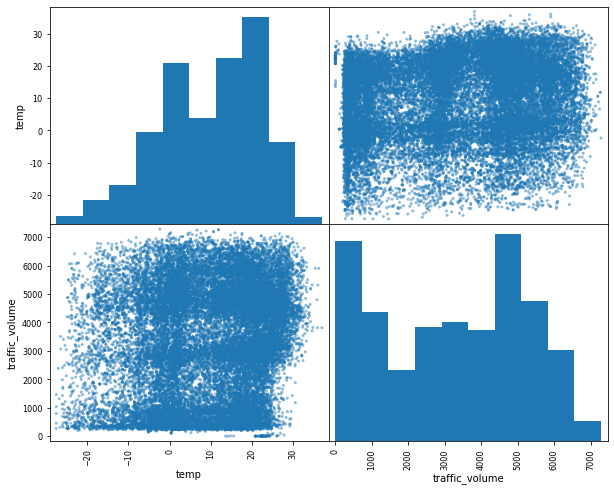

In [19]:
num_vars = ['temp', 'traffic_volume']
scatter_matrix(df[num_vars],figsize=(10,8))
plt.show()

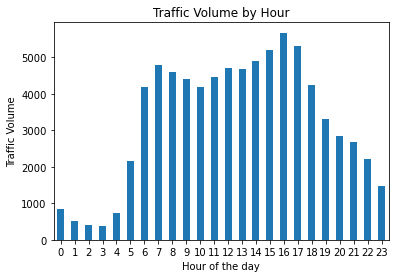

In [20]:
# # convert date_time column to datetime type
df['date_time'] = pd.to_datetime(df['date_time'])
df1 = df.copy()
# Plot traffic volume by hour of the day
df1.groupby(df1["date_time"].dt.hour)["traffic_volume"].mean().plot(kind='bar', rot=0)
plt.xlabel("Hour of the day");
plt.ylabel("Traffic Volume");
plt.title("Traffic Volume by Hour");

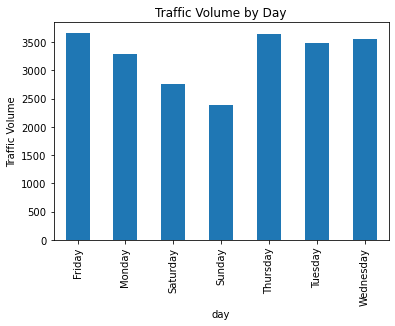

In [21]:
#Plot traffic volume by day of the month
df1.groupby(df1["date_time"].dt.day_name())["traffic_volume"].mean().plot(kind='bar')
plt.xlabel("day");
plt.ylabel("Traffic Volume");
plt.title("Traffic Volume by Day");

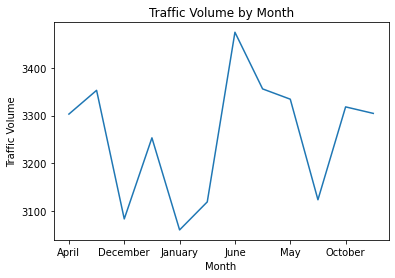

In [22]:
#Plot traffic volume by month
df1.groupby(df1["date_time"].dt.month_name())["traffic_volume"].mean().plot()
plt.xlabel("Month");
plt.ylabel("Traffic Volume");
plt.title("Traffic Volume by Month");

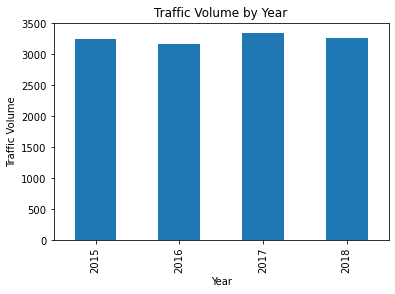

In [23]:
#Plot traffic volume by year
df1.groupby(df1["date_time"].dt.year)["traffic_volume"].mean().plot(kind='bar')
plt.xlabel("Year",);
plt.ylabel("Traffic Volume");
plt.title("Traffic Volume by Year");

##### Focus on the timestamps to create features: 
###### Extract hour, day and month features from the time-stamps.  

In [24]:
df1['Month'] = df1.date_time.dt.month
df1['Day_of_Week'] = df1.date_time.dt.day_of_week
df1['Hour_of_Day'] = df1.date_time.dt.hour

#setting date as index
df1.set_index('date_time', inplace = True)
df1.head()

,rain_1h,snow_1h,temp,clouds_all,traffic_volume,Month,Day_of_Week,Hour_of_Day
date_time,,,,,,,,
2015-07-01 00:00:00,No_Rain,No_Snow,16.05,clear_sky,737,7,2,0
2015-07-01 01:00:00,No_Rain,No_Snow,16.25,clear_sky,444,7,2,1
2015-07-01 02:00:00,No_Rain,No_Snow,16.04,clear_sky,347,7,2,2
2015-07-01 03:00:00,Rained,No_Snow,15.59,clear_sky,356,7,2,3
2015-07-01 04:00:00,No_Rain,No_Snow,14.92,clear_sky,936,7,2,4


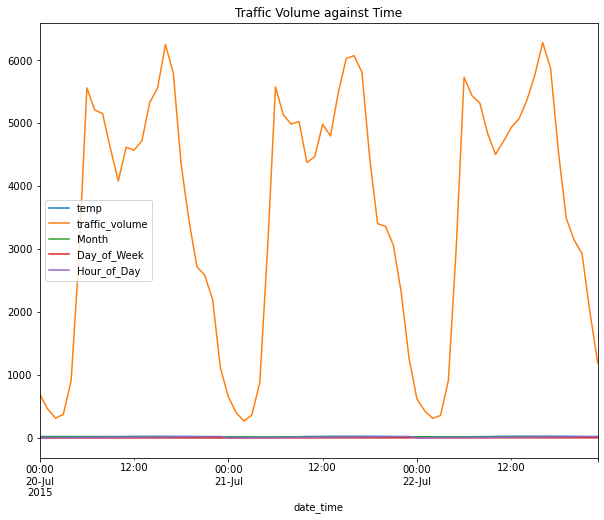

In [25]:
df1["2015-07-20":"2015-07-22"].plot(figsize=(10,8));
plt.title('Traffic Volume against Time');

#Below is a plot  of traffic volume over a three day period and we can see similar patterns with slight differences that occur usually around midday. 

##### Employ the usual Train-test split approach: 
###### Dividing the data into train and test sets keeping one third of the data for testing.

In [26]:
df1.head()

,rain_1h,snow_1h,temp,clouds_all,traffic_volume,Month,Day_of_Week,Hour_of_Day
date_time,,,,,,,,
2015-07-01 00:00:00,No_Rain,No_Snow,16.05,clear_sky,737,7,2,0
2015-07-01 01:00:00,No_Rain,No_Snow,16.25,clear_sky,444,7,2,1
2015-07-01 02:00:00,No_Rain,No_Snow,16.04,clear_sky,347,7,2,2
2015-07-01 03:00:00,Rained,No_Snow,15.59,clear_sky,356,7,2,3
2015-07-01 04:00:00,No_Rain,No_Snow,14.92,clear_sky,936,7,2,4


In [27]:
y_name = "traffic_volume"
y = df1[y_name]

X = df1.drop(columns=[y_name])

In [28]:
#Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3,  random_state=42)

##### Interesting bit here!; The comparisons:
###### Building two different regression models and test the accuracy. Try Linear Regression and one other regression model from scikit learn.

In [29]:
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(X)
categorical_columns = categorical_columns_selector(X)

categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = StandardScaler()

preprocessor = ColumnTransformer([('one-hot-encoder', categorical_preprocessor, categorical_columns), ('standard_scaler', numerical_preprocessor, numerical_columns)])

In [30]:
reg_model = make_pipeline(preprocessor, LinearRegression())
reg_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('one-hot-encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['rain_1h', 'snow_1h',
                                                   'clouds_all']),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['temp', 'Month',
                                                   'Day_of_Week',
                                                   'Hour_of_Day'])])),
                ('linearregression', LinearRegression())])

In [31]:
_regM = reg_model.fit(X_train, y_train)
reg_model.predict(X_test)
reg_model.score(X_test, y_test)

0.16218269567889865

In [32]:
sgd_model = make_pipeline(preprocessor, SGDRegressor(max_iter=200, tol=1e-3))
sgd_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('one-hot-encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['rain_1h', 'snow_1h',
                                                   'clouds_all']),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['temp', 'Month',
                                                   'Day_of_Week',
                                                   'Hour_of_Day'])])),
                ('sgdregressor', SGDRegressor(max_iter=200))])

In [33]:
_sgdM = sgd_model.fit(X_train, y_train)
sgd_model.predict(X_test)
sgd_model.score(X_test, y_test)

0.1614421447751503

##### Now we test:
###### Given that the linear numeric encoding of the hour, day and month features may miss cyclical signals, investigate and test a cyclical strategy for encoding these features. Does this strategy improve accuracy for the models tested earlier?


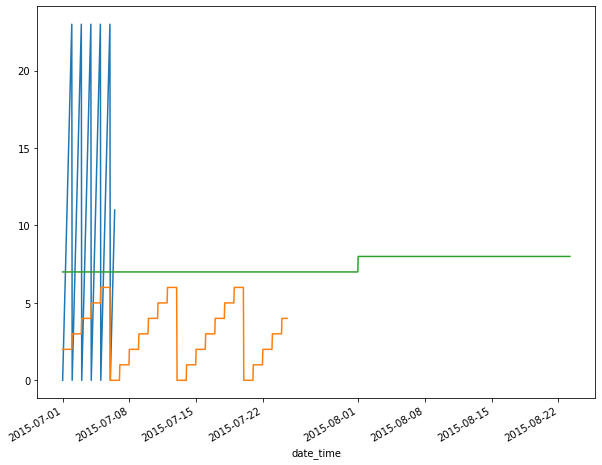

In [34]:
hour= df1[:168]['Hour_of_Day'].plot(figsize=(10,8))
day =df1[:672]['Day_of_Week'].plot(figsize=(10,8))
month = df1[:1500]['Month'].plot(figsize=(10,8))

###### From above we can see that the issues that arise with cyclical signals  for example with the hour graph (blue), there are jump discontinuities in the graph at the end of each day(when the hour value goes from  23  to  00)  and month with 31 to 1 and 12 to 1. The difference in time for example between records 10 and 11 is of course  1  hour. If we leave the hour feature unencoded, everything works in this case:  23−22=1 However, if we look at rows with 23 and 0 below we see the failure in our encoding:  0−23=−23 , even though the records are again only one hour apart. We need to change the encoding of the feature such that midnight and 11:00PM are the same distance apart as any other two hours.   

In [35]:
df1[:168][21:25]

,rain_1h,snow_1h,temp,clouds_all,traffic_volume,Month,Day_of_Week,Hour_of_Day
date_time,,,,,,,,
2015-07-01 22:00:00,No_Rain,No_Snow,16.52,clear_sky,2356,7,2,22
2015-07-01 23:00:00,No_Rain,No_Snow,14.95,clear_sky,2820,7,2,23
2015-07-02 00:00:00,No_Rain,No_Snow,14.21,clear_sky,1265,7,3,0
2015-07-02 01:00:00,No_Rain,No_Snow,13.32,clear_sky,566,7,3,1


In [36]:
df1['hour_sin'] = np.sin(2 * np.pi * df1['Hour_of_Day']/24.0)
df1['hour_cos'] = np.cos(2 * np.pi * df1['Hour_of_Day']/24.0)

In [37]:
def encode(df1, col, max_val):
    df1[col + '_sin'] = np.sin(2 * np.pi * df1[col]/max_val)
    df1[col + '_cos'] = np.cos(2 * np.pi * df1[col]/max_val)
    return df1

In [38]:
df1= encode(df1, 'Month', 12)
df1= encode(df1, 'Day_of_Week', 7)

In [39]:
df1

,rain_1h,snow_1h,temp,clouds_all,traffic_volume,Month,Day_of_Week,Hour_of_Day,hour_sin,hour_cos,Month_sin,Month_cos,Day_of_Week_sin,Day_of_Week_cos
date_time,,,,,,,,,,,,,,
2015-07-01 00:00:00,No_Rain,No_Snow,16.05,clear_sky,737,7,2,0,0.000000,1.000000,-0.5,-8.660254e-01,0.974928,-0.222521
2015-07-01 01:00:00,No_Rain,No_Snow,16.25,clear_sky,444,7,2,1,0.258819,0.965926,-0.5,-8.660254e-01,0.974928,-0.222521
2015-07-01 02:00:00,No_Rain,No_Snow,16.04,clear_sky,347,7,2,2,0.500000,0.866025,-0.5,-8.660254e-01,0.974928,-0.222521
2015-07-01 03:00:00,Rained,No_Snow,15.59,clear_sky,356,7,2,3,0.707107,0.707107,-0.5,-8.660254e-01,0.974928,-0.222521
2015-07-01 04:00:00,No_Rain,No_Snow,14.92,clear_sky,936,7,2,4,0.866025,0.500000,-0.5,-8.660254e-01,0.974928,-0.222521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-30 19:00:00,No_Rain,No_Snow,10.30,trace_sky,3543,9,6,19,-0.965926,0.258819,-1.0,-1.836970e-16,-0.781831,0.623490
2018-09-30 20:00:00,No_Rain,No_Snow,9.61,trace_sky,2781,9,6,20,-0.866025,0.500000,-1.0,-1.836970e-16,-0.781831,0.623490
2018-09-30 21:00:00,No_Rain,No_Snow,9.58,trace_sky,2159,9,6,21,-0.707107,0.707107,-1.0,-1.836970e-16,-0.781831,0.623490


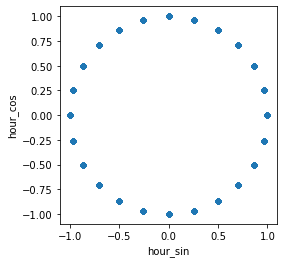

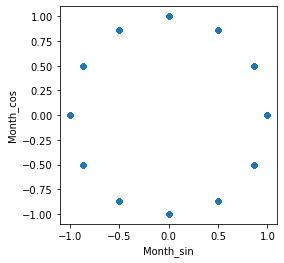

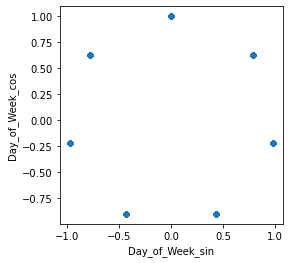

In [40]:
df1.plot.scatter('hour_sin', 'hour_cos').set_aspect('equal')
df1.plot.scatter('Month_sin', 'Month_cos').set_aspect('equal')
df1.plot.scatter('Day_of_Week_sin', 'Day_of_Week_cos').set_aspect('equal')

In [41]:
df1.head(2)

,rain_1h,snow_1h,temp,clouds_all,traffic_volume,Month,Day_of_Week,Hour_of_Day,hour_sin,hour_cos,Month_sin,Month_cos,Day_of_Week_sin,Day_of_Week_cos
date_time,,,,,,,,,,,,,,
2015-07-01 00:00:00,No_Rain,No_Snow,16.05,clear_sky,737,7,2,0,0.000000,1.000000,-0.5,-0.866025,0.974928,-0.222521
2015-07-01 01:00:00,No_Rain,No_Snow,16.25,clear_sky,444,7,2,1,0.258819,0.965926,-0.5,-0.866025,0.974928,-0.222521


In [42]:
df2 = df1[['rain_1h', 'snow_1h', 'temp', 'clouds_all', 'traffic_volume', 'hour_sin', 'hour_cos', 'Month_sin', 'Month_cos', 'Day_of_Week_sin', 'Day_of_Week_cos']].copy()

In [43]:
df2.head(2)

,rain_1h,snow_1h,temp,clouds_all,traffic_volume,hour_sin,hour_cos,Month_sin,Month_cos,Day_of_Week_sin,Day_of_Week_cos
date_time,,,,,,,,,,,
2015-07-01 00:00:00,No_Rain,No_Snow,16.05,clear_sky,737,0.000000,1.000000,-0.5,-0.866025,0.974928,-0.222521
2015-07-01 01:00:00,No_Rain,No_Snow,16.25,clear_sky,444,0.258819,0.965926,-0.5,-0.866025,0.974928,-0.222521


In [44]:
y_name = "traffic_volume"
y = df2[y_name]

X = df2.drop(columns=[y_name])

In [45]:
#Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3,  random_state=42)

In [46]:
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(X)
categorical_columns = categorical_columns_selector(X)

categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = StandardScaler()

preprocessor = ColumnTransformer([('one-hot-encoder', categorical_preprocessor, categorical_columns), ('standard_scaler', numerical_preprocessor, numerical_columns)])

In [47]:
reg_model = make_pipeline(preprocessor, LinearRegression())
reg_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('one-hot-encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['rain_1h', 'snow_1h',
                                                   'clouds_all']),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['temp', 'hour_sin',
                                                   'hour_cos', 'Month_sin',
                                                   'Month_cos',
                                                   'Day_of_Week_sin',
                                                   'Day_of_Week_cos'])])),
                ('linearregression', LinearRegression())])

In [48]:
_regM = reg_model.fit(X_train, y_train)
reg_model.predict(X_test)
reg_model.score(X_test, y_test)

0.6853110318574205

In [49]:
sgd_model = make_pipeline(preprocessor, SGDRegressor(max_iter=200, tol=1e-3))
sgd_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('one-hot-encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['rain_1h', 'snow_1h',
                                                   'clouds_all']),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['temp', 'hour_sin',
                                                   'hour_cos', 'Month_sin',
                                                   'Month_cos',
                                                   'Day_of_Week_sin',
                                                   'Day_of_Week_cos'])])),
                ('sgdregressor', SGDRegressor(max_iter=200))])

In [50]:
_sgdM = sgd_model.fit(X_train, y_train)
y_pred = sgd_model.predict(X_test)
sgd_model.score(X_test, y_test)

0.6852183478477507

###### This encoding approach for cyclical features has improved the prediction accuracy of both regression models from as low as 0.16 accuracy from linear regression and 0.15 SGDRegressor to 0.68 for both models.

##### Also noted at this point is both Regression models employed hereat this point are very close in regards to their score. 

##### Focusing on Model specific subsets:
##### Identifing effective subsets of the features for this prediction task. These can be the same subset for all models or model-specific subsets. 

In [51]:
df2.dtypes

rain_1h             object
snow_1h             object
temp               float64
clouds_all          object
traffic_volume       int64
hour_sin           float64
hour_cos           float64
Month_sin          float64
Month_cos          float64
Day_of_Week_sin    float64
Day_of_Week_cos    float64
dtype: object

In [52]:
dfN = df2.select_dtypes(include=np.number)

In [53]:
dfN

,temp,traffic_volume,hour_sin,hour_cos,Month_sin,Month_cos,Day_of_Week_sin,Day_of_Week_cos
date_time,,,,,,,,
2015-07-01 00:00:00,16.05,737,0.000000,1.000000,-0.5,-8.660254e-01,0.974928,-0.222521
2015-07-01 01:00:00,16.25,444,0.258819,0.965926,-0.5,-8.660254e-01,0.974928,-0.222521
2015-07-01 02:00:00,16.04,347,0.500000,0.866025,-0.5,-8.660254e-01,0.974928,-0.222521
2015-07-01 03:00:00,15.59,356,0.707107,0.707107,-0.5,-8.660254e-01,0.974928,-0.222521
2015-07-01 04:00:00,14.92,936,0.866025,0.500000,-0.5,-8.660254e-01,0.974928,-0.222521
...,...,...,...,...,...,...,...,...
2018-09-30 19:00:00,10.30,3543,-0.965926,0.258819,-1.0,-1.836970e-16,-0.781831,0.623490
2018-09-30 20:00:00,9.61,2781,-0.866025,0.500000,-1.0,-1.836970e-16,-0.781831,0.623490
2018-09-30 21:00:00,9.58,2159,-0.707107,0.707107,-1.0,-1.836970e-16,-0.781831,0.623490


In [54]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

X = dfN[['temp', 'hour_sin', 'hour_cos', 'Month_sin', 'Month_cos', 'Day_of_Week_sin', 'Day_of_Week_cos']].values
y = dfN.pop('traffic_volume').values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)

In [55]:
# pearson's correlation approach
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import f_regression

fs = SelectKBest(score_func=f_regression,  k=4)

X_sel = fs.fit_transform(X, y)
print(X_sel.shape)

(32047, 4)


In [56]:
X_sel

array([[16.05      ,  0.        ,  1.        ,  0.97492791],
       [16.25      ,  0.25881905,  0.96592583,  0.97492791],
       [16.04      ,  0.5       ,  0.8660254 ,  0.97492791],
       ...,
       [ 9.58      , -0.70710678,  0.70710678, -0.78183148],
       [ 8.94      , -0.5       ,  0.8660254 , -0.78183148],
       [ 8.97      , -0.25881905,  0.96592583, -0.78183148]])

In [7]:
metro_traffic

,date_time,rain_1h,snow_1h,temp,clouds_all,traffic_volume
0,2015-07-01 00:00:00,0.0,0.0,289.20,1,737
1,2015-07-01 01:00:00,0.0,0.0,289.40,1,444
2,2015-07-01 02:00:00,0.0,0.0,289.19,1,347
3,2015-07-01 03:00:00,0.3,0.0,288.74,1,356
4,2015-07-01 04:00:00,0.0,0.0,288.07,1,936
...,...,...,...,...,...,...
32042,2018-09-30 19:00:00,0.0,0.0,283.45,75,3543
32043,2018-09-30 20:00:00,0.0,0.0,282.76,90,2781
32044,2018-09-30 21:00:00,0.0,0.0,282.73,90,2159
32045,2018-09-30 22:00:00,0.0,0.0,282.09,90,1450


In [8]:
metro_traffic_small = metro_traffic.iloc[0:100]

In [12]:
X = metro_traffic_small.iloc[:,1:4]
y = metro_traffic_small.iloc[:,5]

In [14]:
y

0      737
1      444
2      347
3      356
4      936
      ... 
95    3011
96    3156
97    3267
98    3198
99    3080
Name: traffic_volume, Length: 100, dtype: int64

In [17]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(random_state=0)
forest.fit(X, y)

RandomForestClassifier(random_state=0)

In [20]:
X

,rain_1h,snow_1h,temp
0,0.0,0.0,289.20
1,0.0,0.0,289.40
2,0.0,0.0,289.19
3,0.3,0.0,288.74
4,0.0,0.0,288.07
...,...,...,...
95,0.0,0.0,298.44
96,0.0,0.0,299.10
97,0.0,0.0,300.28
98,0.0,0.0,300.90


In [18]:
importances = forest.feature_importances_

In [19]:
importances

array([0.0096461, 0.       , 0.9903539])

#### Focusing on the numeric columns, and setting the required number of columns to 3 (k=3) we can see that the best selection for the numeric columns is hour_sin, hour_cos and Day_of_week_sin( if we extend k to 4 features we get temp as the 4th ranked numerical column)